In [2]:
from PIL import Image
import matplotlib.pyplot as plt

from src.gans import Modifier
from src.search import AkiwiFeatureGenerator, ResnetFeatureGenerator, Search, CombinedSearch

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_img_row(images, img_labels=None):
    fig, axarr = plt.subplots(nrows=1, ncols=len(images), figsize=(len(images)*3, 4))
    
    for i, img in enumerate(images):
        ax = axarr[i]
        img = img.resize([256, 256])
        img = img.crop((40, 0, 216, 256))
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        
        for spine in ax.spines.keys():
            ax.spines[spine].set_visible(False)
        
        if img_labels is not None:
            ax.set_title(img_labels[i])
        
    plt.show()

# Load Search Models
Load Resnet and Akiwi50 features to retrieve with combined Resnet50 features.

In [5]:
folder_gens = {'akiwi_50': AkiwiFeatureGenerator(50), 
               'resnet': ResnetFeatureGenerator()}

In [6]:
dress_imgs = './data/images/fashion/dresses/'
model_imgs = './data/images/fashion_models/dresses_clustered/'

dress_feats = './data/features/fashion/dresses/'
model_feats = './data/features/fashion_models/dresses/'

In [7]:
dress_search = {}
for dir_name, gen in folder_gens.items():
    dress_search[dir_name] = Search(dress_imgs, os.path.join(dress_feats, dir_name), gen)

Loading features from: ./data/features/fashion/dresses/akiwi_50
Loading features from: ./data/features/fashion/dresses/resnet


In [8]:
model_search = {}
for dir_name, gen in folder_gens.items():
    model_search[dir_name] = Search(model_imgs, os.path.join(model_feats, dir_name), gen)

Loading features from: ./data/features/fashion_models/dresses/akiwi_50
Loading features from: ./data/features/fashion_models/dresses/resnet


In [9]:
# combined search
dress_resnet50 = CombinedSearch([dress_search['akiwi_50'], dress_search['resnet']], factors=[2, 1])
model_resnet50 = CombinedSearch([model_search['akiwi_50'], model_search['resnet']], factors=[2, 1])

# Modifications
With *modifier* you can modify attributes and their values for a given input image.

Following are possible attributes and their values for each function:

**modifier.modify_shape()** 
- sleeve_length: long, 3/4, short, sleeveless
- fit: normal, loose, tight
- neckline: round, v, wide

**modifier.modify_pattern()**
- floral: to, from
- stripes: to, from

**modifier.product_to_model()**
- no parameters, generates a model image from the product image

In [36]:
modifier = Modifier('./data/models/')

In [63]:
def run_pipeline(input_img, pipeline, search, search_kwargs={}):
    """
    For the input image, run the modifications included in pipeline list. 
    After each modiciatio, search for similar images and plot results.
    
    Parameters:
        input_img: PIL Image to modify
        pipeline: list of tuples such as: [(modify_function1, kwargs1), (modify_function2, kwargs2)]
        search: Search or CombinedSearch object
        search_kwargs: if not provided, use default Search args
    """
    
    def plot_modified_search(modified_img):
        sim_imgs = search.get_similar_images(img=modified_img, **search_kwargs)
        print('Similar images path', sim_imgs)
        plot_img_row([modified_img] + [Image.open(i) for i in sim_imgs])
        
    modified_img = input_img
    
    for mod_fun, kwargs in pipeline:
        print(kwargs)
        modified_img = mod_fun(image=modified_img, **kwargs)
        plot_modified_search(modified_img)
    
    return mod_img

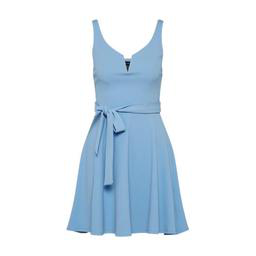

In [71]:
test_img = Image.open('./data/images/test_images/dresses/NEW1407001000004.jpg')
test_img

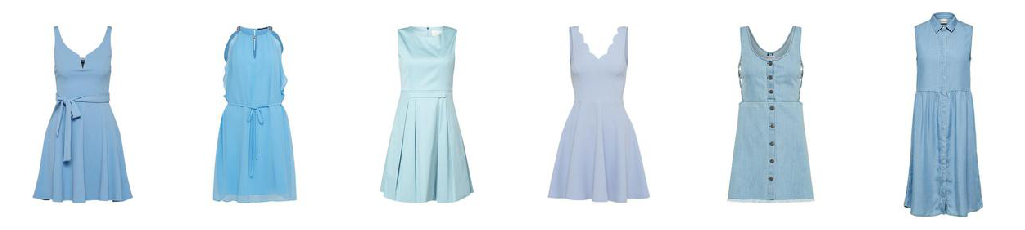

In [73]:
plot_img_row([Image.open(i) for i in dress_resnet50.get_similar_images(test_img, num_imgs=6, metric='l1')])

{'attribute': 'sleeve_length', 'value': 'long'}
Similar images path ['./data/images/fashion/dresses/PEP0919001002000.jpg', './data/images/fashion/dresses/SIS0666006000001.jpg', './data/images/fashion/dresses/VER1503001000005.jpg', './data/images/fashion/dresses/MF921C0J3-K11.jpg', './data/images/fashion/dresses/ED121C0D3-K11.jpg']


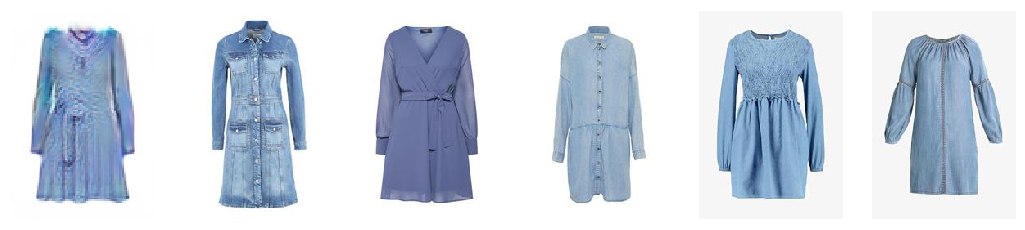

{'attribute': 'floral', 'value': 'to'}
Similar images path ['./data/images/fashion/dresses/VE121C1AJ-K11.jpg', './data/images/fashion/dresses/V1021C156-K11.jpg', './data/images/fashion/dresses/SIS0656001000001.jpg', './data/images/fashion/dresses/9819654.jpg', './data/images/fashion/dresses/9810810.jpg']


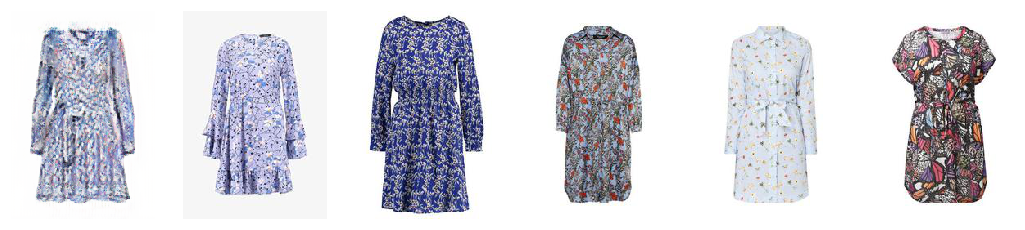

In [74]:
pipeline = [
    (modifier.modify_shape, {'attribute': 'sleeve_length', 'value': 'long'}),
    (modifier.modify_pattern, {'attribute': 'floral', 'value': 'to'})
]

modified_img = run_pipeline(test_img, pipeline, dress_resnet50, 
                       search_kwargs={'metric': 'l1', 'num_imgs': 5})

{'attribute': 'floral', 'value': 'to'}
Similar images path ['./data/images/fashion/dresses/STT0179001000001.jpg', './data/images/fashion/dresses/Jnr0102001000005.jpg', './data/images/fashion/dresses/9854009.jpg', './data/images/fashion/dresses/5713781271617.jpg', './data/images/fashion/dresses/9858536.jpg']


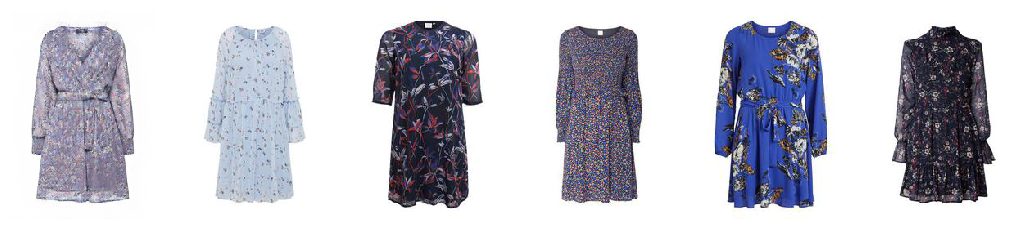

In [75]:
test_img = Image.open('./data/images/fashion/dresses/SIS0666006000001.jpg')
pipeline = [
    (modifier.modify_pattern, {'attribute': 'floral', 'value': 'to'})
]

modified_img = run_pipeline(test_img, pipeline, dress_resnet50, 
                       search_kwargs={'metric': 'l1', 'num_imgs': 5})

In [ ]:
model_img = run_pipeline(modified_img, [(modifier.product_to_model, {})], model_resnet50,
                        {'metric': 'l1', 'num_imgs': 5})